In [20]:
# 모듈 로딩
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [21]:
bikeDF = pd.read_csv(r'C:\Users\KDP-17\EX_PANDAS6\MachineLearning\data\bike_train.csv')
print(bikeDF.shape)
bikeDF.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [22]:
bikeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [23]:
# 문자열을 datetime으로 변경
bikeDF['datetime'] = bikeDF.datetime.apply(pd.to_datetime)

# datetime 타입에서 년,월,일,시간 추출
bikeDF['year'] = bikeDF.datetime.apply(lambda x : x.year)
bikeDF['month'] = bikeDF.datetime.apply(lambda x : x.month)
bikeDF['day'] = bikeDF.datetime.apply(lambda x : x.day)
bikeDF['hour'] = bikeDF.datetime.apply(lambda x : x.hour)
bikeDF.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [24]:
# 필요없는 컬럼 삭제
drop_columns = ['datetime', 'casual', 'registered']
bikeDF.drop(drop_columns, axis=1, inplace=True)

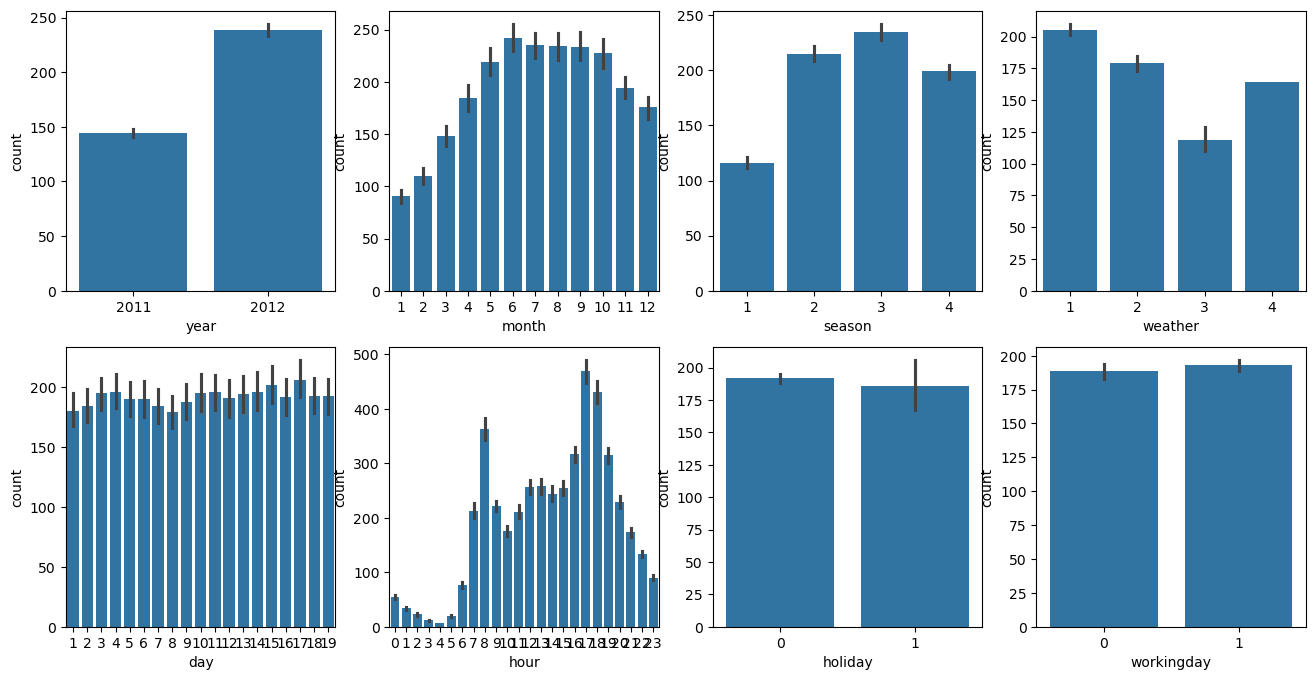

In [25]:
# 컬럼 시각화
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    #시본 barplot 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bikeDF, ax=axs[row][col])

회귀 모델 데이터 세트에 적용해 예측 성능 측정

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) **2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MAE, RMSE, RMSEL를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)
    print(f'RMSLE : {rmsle_val}, RMSE: {rmse_val}, MAE : {mae_val}')    

로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [27]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bikeDF['count']
X_features = bikeDF.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features,y_target,test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE : 1.1646636237111023, RMSE: 140.8995886716559, MAE : 105.9244483510065


In [28]:
# 실제 값과 예측값이 어느정도 차이가 나는지 확인
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    resultDF = pd.DataFrame(y_test.values, columns=['real_count'])
    resultDF['predicted_count'] = np.round(pred)
    resultDF['diff'] = np.abs(resultDF['real_count'] - resultDF['predicted_count'])

# 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(resultDF.sort_values('diff', ascending=False)[:n_tops])
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

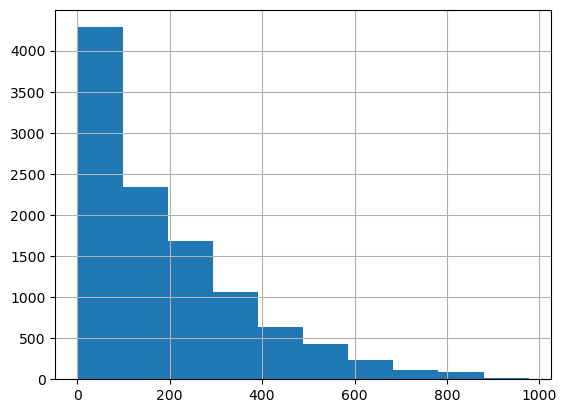

In [29]:
# 정규분포인지 확인
y_target.hist()

왜곡된 값을 정규분포로 변형하는 방법은 로그 적용시키기

<Axes: >

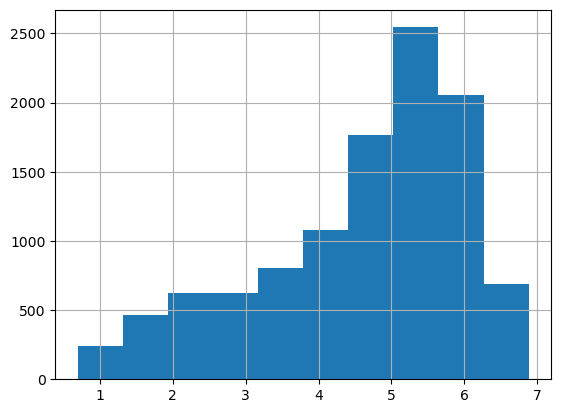

In [30]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [31]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3,
                                                    random_state=10)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE : 1.0385535563209027, RMSE: 161.8951233945898, MAE : 107.70028802362448


<Axes: ylabel='None'>

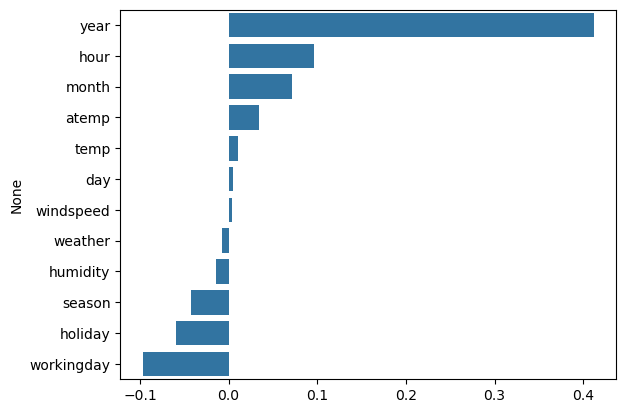

In [32]:
# 개별 피쳐 인코딩 적용

coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

회귀 계수 영향도가 높지만 카테고리형 피쳐인 year, hour, month를 원-핫 인코딩 적용해 변환

In [33]:
# year, month, day, hour등의 피쳐들을 One hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

# 원-핫 인코딩이 적용된 피쳐 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3,
                                                    random_state=10)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=100)
Lasso_reg = Lasso(alpha=0.01)


for model in [lr_reg, ridge_reg, Lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### LinearRegression ###
RMSLE : 0.5880638255351067, RMSE: 96.8965067003614, MAE : 62.67117680878832
### Ridge ###
RMSLE : 0.6687988370127147, RMSE: 114.27640973769157, MAE : 72.31413507230377
### Lasso ###
RMSLE : 0.6434928696630924, RMSE: 114.53625089378639, MAE : 72.7953366534738


원 핫 인코딩된 데이터세트의 회귀 계수가 높은 피쳐 시각화

<Axes: ylabel='None'>

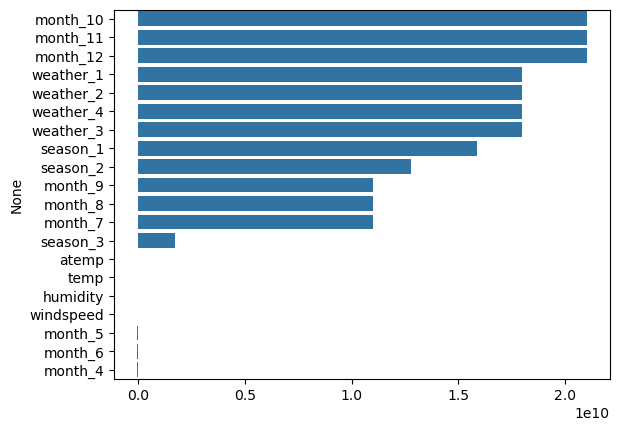

In [39]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)